In [1]:
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, cross_val_score, ShuffleSplit, train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
import sklearn

import numpy as np
import copy
from MDWM import MDWM

from pyriemann.classification import MDM, TSclassifier, KNearestNeighbor, FgMDM
from pyriemann.utils.mean import mean_covariance
from pyriemann.estimation import Covariances,XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from moabb.paradigms import SSVEP, FilterBankSSVEP
from moabb.evaluations import WithinSessionEvaluation
from moabb.datasets import SSVEPExo
from moabb.pipelines import ExtendedSSVEPSignal

from mne.decoding import CSP

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = SSVEPExo()

In [3]:
paradigm = FilterBankSSVEP(filters=None, n_classes=4)

Choosing the first 4 classes from all possible events


In [4]:
#Classifieur MDWM seulement 
# sur 12 sujets
n_boot = 4
n_samples = range(1, 9, 3)  # Nombre de samples par class pour un subject 
lambdas = np.linspace(0.1, 0.9, 3) # 6 valeurs de Lambda
subjects = dataset.subject_list[:12]
n_classes = 4
transfer_results = []

for s in subjects:
    signal_target, labels_target, metadata_target = paradigm.get_data(dataset = dataset, subjects= [s])
    X = ExtendedSSVEPSignal().fit_transform(signal_target, labels_target)   #données Extented en 3D
    domain_subjects = list(set(subjects) - set([s]))
    print("Target subject {}, training on {}".format(s, domain_subjects))
    signal_domain, labels_domain, metadata_domain = paradigm.get_data(dataset=dataset, subjects=domain_subjects)
    X_domain = ExtendedSSVEPSignal().fit_transform(signal_domain, labels_domain)   #données Extented en 3D
    X_domain = Covariances(estimator='lwf').fit_transform(X_domain)
    
    for L in lambdas:
        for ns in n_samples:
            print ("- L={}, ns={} : computing accuracy on {} bootstrap".format(L, ns, n_boot))
            Bootstrap = StratifiedShuffleSplit(n_splits=n_boot, train_size=ns*n_classes, random_state=42)  #faire des cross sur le target
            for train_index, test_index in Bootstrap.split(X, labels_target):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = labels_target[train_index], labels_target[test_index] 
                mdwm = make_pipeline(Covariances(estimator='lwf'),
                                    MDWM(metric='riemann', L=L, n_jobs=-1))
                mdwm.fit(X_train, y_train, mdwm__X_domain=X_domain, mdwm__y_domain=labels_domain)
                y_pred = mdwm.predict(X_test)
                acc_mdwm = accuracy_score(y_test, y_pred)
                transfer_results.append({'classifier':'MDWM', 'accuracy':acc_mdwm, 'samples per class':ns,
                                        'subject':s, 'lambda':L, 'dataset':'SSVEPExo'})

    
    
df_transfer = pd.DataFrame(transfer_results)

/home/sylchev/src/github/moabb/moabb/datasets/download.py:53: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_SSVEPEXO_PATH"
  set_config(key, osp.join(osp.expanduser("~"), "mne_data"))


Target subject 1, training on [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
- L=0.1, ns=1 : computing accuracy on 4 bootstrap
- L=0.1, ns=4 : computing accuracy on 4 bootstrap
- L=0.1, ns=7 : computing accuracy on 4 bootstrap
- L=0.5, ns=1 : computing accuracy on 4 bootstrap
- L=0.5, ns=4 : computing accuracy on 4 bootstrap
- L=0.5, ns=7 : computing accuracy on 4 bootstrap
- L=0.9, ns=1 : computing accuracy on 4 bootstrap
- L=0.9, ns=4 : computing accuracy on 4 bootstrap
- L=0.9, ns=7 : computing accuracy on 4 bootstrap
Target subject 2, training on [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
- L=0.1, ns=1 : computing accuracy on 4 bootstrap
- L=0.1, ns=4 : computing accuracy on 4 bootstrap
- L=0.1, ns=7 : computing accuracy on 4 bootstrap
- L=0.5, ns=1 : computing accuracy on 4 bootstrap
- L=0.5, ns=4 : computing accuracy on 4 bootstrap
- L=0.5, ns=7 : computing accuracy on 4 bootstrap
- L=0.9, ns=1 : computing accuracy on 4 bootstrap
- L=0.9, ns=4 : computing accuracy on 4 bootstrap
- L=0.9, ns=7 : 

<Figure size 1080x504 with 0 Axes>

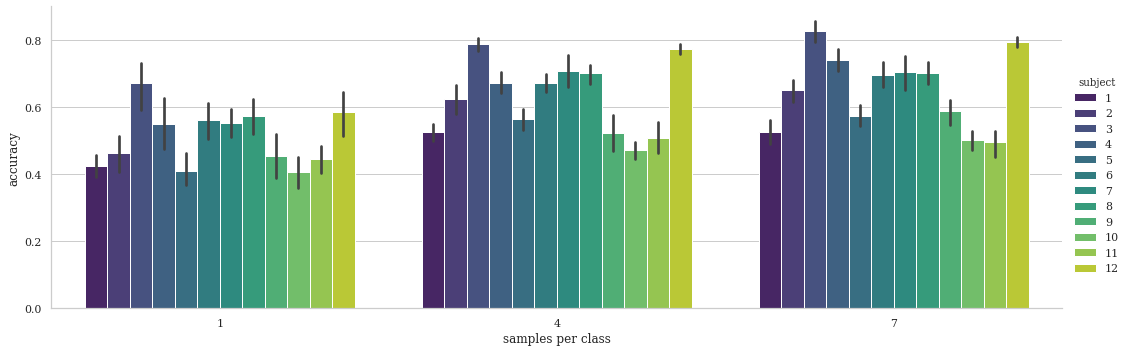

In [19]:
#Accuracy en fonction du nombre d'échantillons par classe
plt.figure(figsize=(15,7))
sns.catplot(data=df_transfer, x='samples per class',height=5,aspect=3 ,y='accuracy', hue='subject', kind='bar', palette='viridis')

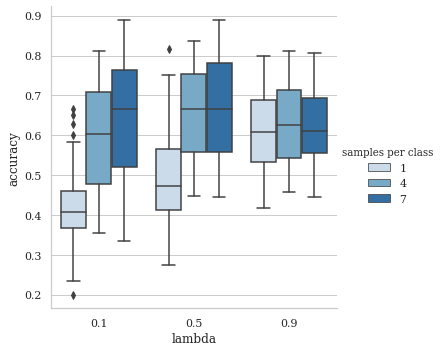

In [6]:
#Accuracy en fonction de lambda
sns.catplot(data=df_transfer, x='lambda', y='accuracy', hue='samples per class', kind='box', palette='Blues')

In [7]:
# Comparaison avec TSLR et MDM
# Sur deux sujets
n_boot = 4
n_samples = range(1, 9, 3)  # Nombre de samples par class pour un subject 
lambdas = np.linspace(0.1, 0.9, 3) # 6 valeurs de Lambda
subjects = dataset.subject_list[4:6]
n_classes = 4
transfer_mdwm, transfer_baseline = [], []

for s in subjects:
    signal_target, labels_target, metadata_target = paradigm.get_data(dataset = dataset, subjects= [s])
    X = ExtendedSSVEPSignal().fit_transform(signal_target, labels_target)   #données Extented en 3D
    domain_subjects = list(set(subjects) - set([s]))
    print("Target subject {}, training on {}".format(s, domain_subjects))
    signal_domain, labels_domain, metadata_domain = paradigm.get_data(dataset=dataset, subjects=domain_subjects)
    X_domain = ExtendedSSVEPSignal().fit_transform(signal_domain, labels_domain)   #données Extented en 3D
    X_domain = Covariances(estimator='lwf').fit_transform(X_domain)
    
    for ns in n_samples:
        for L in lambdas:
            print ("- L={}, ns={} : computing accuracy on {} bootstrap".format(L, ns, n_boot))
            Bootstrap = StratifiedShuffleSplit(n_splits=n_boot, train_size=ns*n_classes, random_state=42)  #faire des cross sur le target
            for train_index, test_index in Bootstrap.split(X, labels_target):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = labels_target[train_index], labels_target[test_index] 
                mdwm = make_pipeline(Covariances(estimator='lwf'),
                                    MDWM(metric='riemann', L=L, n_jobs=-1))
                mdwm.fit(X_train, y_train, mdwm__X_domain=X_domain, mdwm__y_domain=labels_domain)
                y_pred_mdwm = mdwm.predict(X_test)
                acc_mdwm = accuracy_score(y_test, y_pred_mdwm)
                transfer_mdwm.append({'classifier':'MDWM', 'accuracy':acc_mdwm, 'samples per class':ns,
                                        'subject':s, 'lambda':L, 'dataset':'SSVEPExo'})
                
                if L == lambdas[0]:
                    # Evaluation seulement 1 fois, lambda n'a pas d'impact sur MDM et TSLR
                    mdm = make_pipeline(Covariances(estimator='lwf'),
                                        MDM(metric='riemann', n_jobs=-1))
                    mdm.fit(X_train, y_train)
                    y_pred_mdm = mdm.predict(X_test)
                    acc_mdm = accuracy_score(y_test, y_pred_mdm)
                    transfer_baseline.append({'classifier':'MDM', 'accuracy':acc_mdm, 'samples per class':ns,
                                            'subject':s, 'dataset':'SSVEPExo'})
                    ts = make_pipeline(Covariances(estimator='lwf'),
                                        TSclassifier(metric='riemann', tsupdate=False))
                    ts.fit(X_train, y_train)
                    y_pred_ts = ts.predict(X_test)
                    acc_ts = accuracy_score(y_test, y_pred_ts)
                    transfer_baseline.append({'classifier':'TSLR', 'accuracy':acc_ts, 'samples per class':ns,
                                            'subject':s, 'dataset':'SSVEPExo'})
                    
                    
df_mdwm = pd.DataFrame(transfer_mdwm)
df_baseline = pd.DataFrame(transfer_baseline)

Target subject 5, training on [6]
- L=0.1, ns=1 : computing accuracy on 4 bootstrap


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be ch

- L=0.5, ns=1 : computing accuracy on 4 bootstrap
- L=0.9, ns=1 : computing accuracy on 4 bootstrap
- L=0.1, ns=4 : computing accuracy on 4 bootstrap


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be ch

- L=0.5, ns=4 : computing accuracy on 4 bootstrap
- L=0.9, ns=4 : computing accuracy on 4 bootstrap
- L=0.1, ns=7 : computing accuracy on 4 bootstrap


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be ch

- L=0.5, ns=7 : computing accuracy on 4 bootstrap
- L=0.9, ns=7 : computing accuracy on 4 bootstrap
Target subject 6, training on [5]
- L=0.1, ns=1 : computing accuracy on 4 bootstrap


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be ch

- L=0.5, ns=1 : computing accuracy on 4 bootstrap
- L=0.9, ns=1 : computing accuracy on 4 bootstrap
- L=0.1, ns=4 : computing accuracy on 4 bootstrap


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be ch

- L=0.5, ns=4 : computing accuracy on 4 bootstrap
- L=0.9, ns=4 : computing accuracy on 4 bootstrap
- L=0.1, ns=7 : computing accuracy on 4 bootstrap


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be ch

- L=0.5, ns=7 : computing accuracy on 4 bootstrap
- L=0.9, ns=7 : computing accuracy on 4 bootstrap


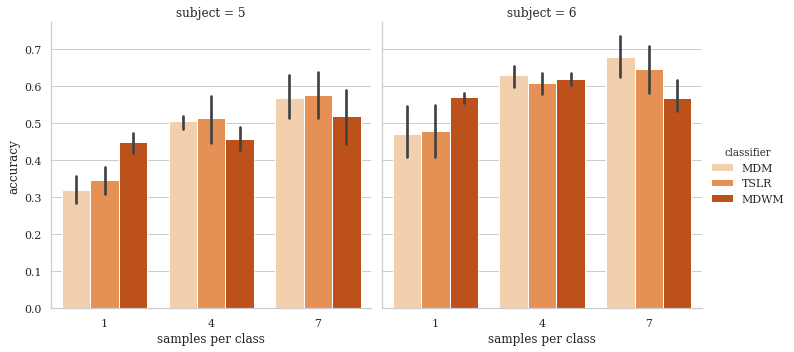

In [8]:
#Comparaison entre classifieurs
df_compare = pd.concat([df_baseline, df_mdwm[df_mdwm['lambda'] == 0.9]], sort=False)
sns.catplot(data=df_compare, x='samples per class', y='accuracy',hue='classifier',
            col='subject', kind='bar', palette='Oranges')

<Figure size 1080x504 with 0 Axes>

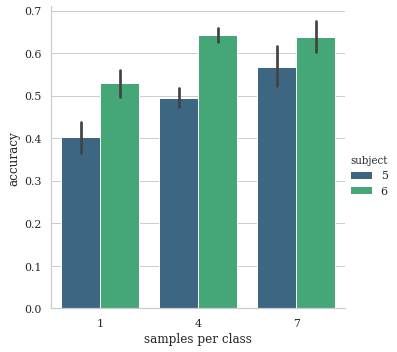

In [14]:
plt.figure(figsize=(15,7))
sns.catplot(data=df_mdwm, x='samples per class', y='accuracy',
            hue='subject', kind='bar', palette='viridis')

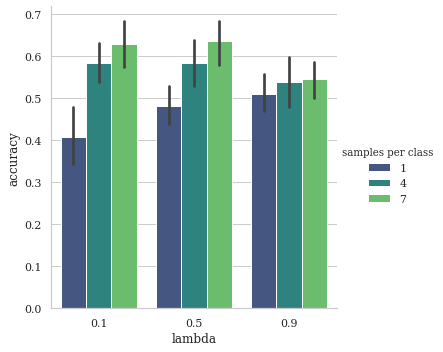

In [10]:
sns.catplot(data=df_mdwm, x='lambda', y='accuracy', hue='samples per class', kind='bar', palette='viridis')